# Scaling up hyperparameter optimization with Kubernetes and XGBoost GPU algorithm

Choosing an optimal set of hyperparameters is a daunting task, especially for algorithms like XGBoost that have many hyperparameters to tune. In this notebook, we will show how to speed up hyperparameter optimization by running multiple training jobs in parallel on a Kubernetes cluster.

# Prerequisites
Please follow instructions in [Dask Operator: Installation](https://docs.rapids.ai/deployment/stable/tools/kubernetes/dask-operator.html#installation) to install the Dask operator on top of a GPU-enabled Kubernetes cluster. (For the purpose of this example, you may ignore other sections of the linked document.) Then install Kubeflow by following instructions in [Installing Kubeflow](https://www.kubeflow.org/docs/started/installing-kubeflow/). You may choose any method; we tested this example after installing Kubeflow from manifests.

# Install system packages

We'll need extra Python packages. In particulare, we need an unreleased version of Optuna:

In [1]:
!pip install dask_kubernetes git+https://github.com/optuna/optuna.git@bc6c05dc655aab7e7a02e91e7306609f2a4524ec

  Cloning https://github.com/optuna/optuna.git (to revision bc6c05dc655aab7e7a02e91e7306609f2a4524ec) to /tmp/pip-req-build-vqgp3w_0
  Running command git clone --filter=blob:none --quiet https://github.com/optuna/optuna.git /tmp/pip-req-build-vqgp3w_0
  Running command git rev-parse -q --verify 'sha^bc6c05dc655aab7e7a02e91e7306609f2a4524ec'
  Running command git fetch -q https://github.com/optuna/optuna.git bc6c05dc655aab7e7a02e91e7306609f2a4524ec
  Running command git checkout -q bc6c05dc655aab7e7a02e91e7306609f2a4524ec
  Resolved https://github.com/optuna/optuna.git to commit bc6c05dc655aab7e7a02e91e7306609f2a4524ec
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.5/145.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 205.9/205.9 kB 31.2 MB/s eta 

# Set up Dask cluster

Let us set up a Dask cluster using the `KubeCluster` class. Fill in the following variables, depending on the configuration of your Kubernetes cluster.

In [2]:
# Choose the same RAPIDS image you used for launching the notebook session
rapids_image = "rapidsai/rapidsai-core:22.10-cuda11.5-runtime-ubuntu20.04-py3.9"
# Use the number of worker nodes in your Kubernetes cluster.
n_workers = 4

In [3]:
from dask_kubernetes.operator import KubeCluster

cluster = KubeCluster(name="rapids-dask",
                      image=rapids_image,
                      worker_command="dask-cuda-worker",
                      n_workers=n_workers,
                      resources={"limits": {"nvidia.com/gpu": "1"}},
                      env={"DISABLE_JUPYTER": "true",
                           "EXTRA_PIP_PACKAGES":
                               "git+https://github.com/optuna/optuna.git@bc6c05dc655aab7e7a02e91e7306609f2a4524ec"})

Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7f0b4652b130>


In [4]:
cluster

Dashboard: /notebook/kubeflow-user-example-com/rapids/proxy/rapids-dask-scheduler.kubeflow-user-example-com:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.36.0.20:8786,Workers: 0
Dashboard: /notebook/kubeflow-user-example-com/rapids/proxy/10.36.0.20:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
from dask.distributed import Client

client = Client(cluster)

# Perform hyperparameter optimization with a toy example

Now we can run hyperparameter optimization. The workers will run multiple training jobs in parallel.

In [6]:
def objective(trial):
    x = trial.suggest_uniform("x", -10, 10)
    return (x - 2) ** 2

In [7]:
import optuna
from dask.distributed import wait

# Number of hyperparameter combinations to try in parallel
n_trials = 100

# Optimize in parallel on your Dask cluster
backend_storage = optuna.storages.InMemoryStorage()
dask_storage = optuna.integration.DaskStorage(storage=backend_storage, client=client)
study = optuna.create_study(direction="minimize", storage=dask_storage)

futures = []
for i in range(0, n_trials, n_workers * 4):
    iter_range = (i, min([i + n_workers * 4, n_trials]))
    futures.append(
        {
            "range": iter_range,
            "futures": [
                client.submit(study.optimize, objective, n_trials=1, pure=False)
                for _ in range(*iter_range)
            ]
        }
    )
for partition in futures:
    iter_range = partition["range"]
    print(f"Testing hyperparameter combinations {iter_range[0]}..{iter_range[1]}")
    _ = wait(partition["futures"])

/tmp/ipykernel_75/1194069379.py:9: ExperimentalWarning: DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.
  dask_storage = optuna.integration.DaskStorage(storage=backend_storage, client=client)


Testing hyperparameter combinations 0..16
Testing hyperparameter combinations 16..32
Testing hyperparameter combinations 32..48
Testing hyperparameter combinations 48..64
Testing hyperparameter combinations 64..80
Testing hyperparameter combinations 80..96
Testing hyperparameter combinations 96..100


In [8]:
study.best_params

{'x': 1.9899853370223668}

In [9]:
study.best_value

0.00010029347455557715

# Perform hyperparameter optimization with XGBoost GPU algorithm

Now let's try optimizing hyperparameters for an XGBoost model.

In [10]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb
from optuna.samplers import RandomSampler

def objective(trial):
    X, y = load_breast_cancer(return_X_y=True)
    params = {
        "n_estimators": 10,
        "verbosity": 0,
        "tree_method": "gpu_hist",
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 100.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 100.0, log=True),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 10, step=1),
        # minimum child weight, larger the term more conservative the tree.
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-8, 100, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 1e-8, 1.0, log=True),
        # defines how selective algorithm is.
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy": "depthwise",
        "eval_metric": "logloss"
    }
    clf = xgb.XGBClassifier(**params)
    fold = KFold(n_splits=5, shuffle=True, random_state=0)
    score = cross_val_score(clf, X, y, cv=fold, scoring='neg_log_loss')
    return score.mean()

In [11]:
# Number of hyperparameter combinations to try in parallel
n_trials = 250

# Optimize in parallel on your Dask cluster
backend_storage = optuna.storages.InMemoryStorage()
dask_storage = optuna.integration.DaskStorage(storage=backend_storage, client=client)
study = optuna.create_study(direction="maximize",
                            sampler=RandomSampler(seed=0),
                            storage=dask_storage)
futures = []
for i in range(0, n_trials, n_workers * 4):
    iter_range = (i, min([i + n_workers * 4, n_trials]))
    futures.append(
        {
            "range": iter_range,
            "futures": [
                client.submit(study.optimize, objective, n_trials=1, pure=False)
                for _ in range(*iter_range)
            ]
        }
    )
for partition in futures:
    iter_range = partition["range"]
    print(f"Testing hyperparameter combinations {iter_range[0]}..{iter_range[1]}")
    _ = wait(partition["futures"])

/tmp/ipykernel_75/1634478960.py:6: ExperimentalWarning: DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.
  dask_storage = optuna.integration.DaskStorage(storage=backend_storage, client=client)


Testing hyperparameter combinations 0..16
Testing hyperparameter combinations 16..32
Testing hyperparameter combinations 32..48
Testing hyperparameter combinations 48..64
Testing hyperparameter combinations 64..80
Testing hyperparameter combinations 80..96
Testing hyperparameter combinations 96..112
Testing hyperparameter combinations 112..128
Testing hyperparameter combinations 128..144
Testing hyperparameter combinations 144..160
Testing hyperparameter combinations 160..176
Testing hyperparameter combinations 176..192
Testing hyperparameter combinations 192..208
Testing hyperparameter combinations 208..224
Testing hyperparameter combinations 224..240
Testing hyperparameter combinations 240..250


In [12]:
study.best_params

{'lambda': 1.9471539598103378,
 'alpha': 1.1141784696858766e-08,
 'colsample_bytree': 0.7422532294369841,
 'max_depth': 4,
 'min_child_weight': 0.2248745054413427,
 'learning_rate': 0.4983200494234886,
 'gamma': 9.77293810275356e-07}

In [13]:
study.best_value

-0.10351124143719839

Let's visualize the progress made by hyperparameter optimization.

In [14]:
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances

/tmp/ipykernel_75/3324289224.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study)


<AxesSubplot: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

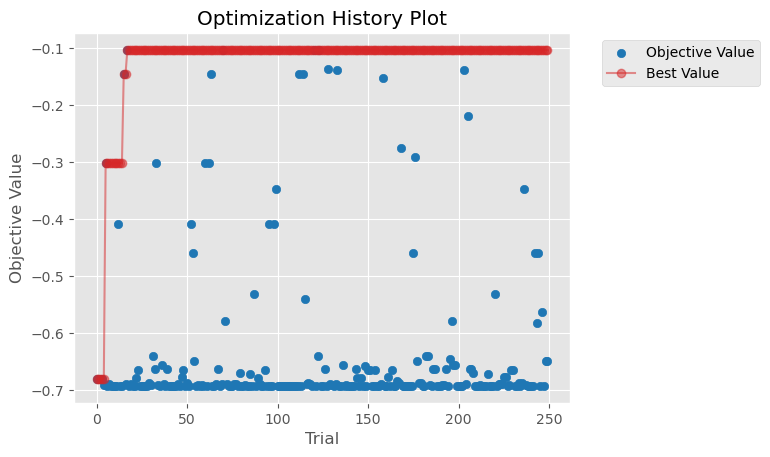

In [15]:
plot_optimization_history(study)

/tmp/ipykernel_75/3836449081.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<AxesSubplot: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

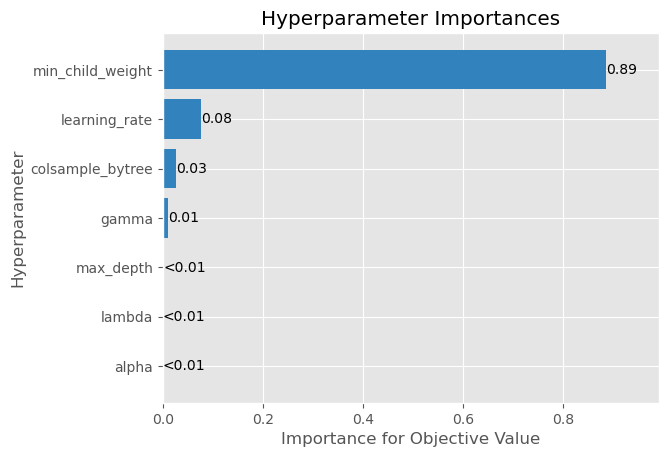

In [16]:
plot_param_importances(study)

# Clean up

In [17]:
cluster.close()